# Marchenko redatuming with 3D dataset - comparison of results

### Author: M.Ravasi

This notebook compares the estimated up-going and total Green's functions for different level of subsampling of reflection response

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import zarr
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt
from scipy.spatial import Voronoi, ConvexHull, voronoi_plot_2d

from pylops.basicoperators import *
from pylops.waveeqprocessing.mdd       import MDC
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.utils import dottest

from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.basicoperators import Diagonal as dDiagonal
from pylops_distributed.basicoperators import Identity as dIdentity
from pylops_distributed.basicoperators import Roll as dRoll
from pylops_distributed.waveeqprocessing.mdd import MDC as dMDC
from pylops_distributed.waveeqprocessing.marchenko import Marchenko as dMarchenko
from pylops_distributed.optimization.cg import cg as dcg

from utils import voronoi_volumes

## Inputs

Input files

In [2]:
os.environ["STORE_PATH"] = "/project/fsenter/mrava/Marchenko3D/"

In [3]:
inputfile_aux = os.environ["STORE_PATH"] + '3DMarchenko_auxiliary_2.npz' 

# subsampling=1
gestfile = 'GreensFunctions/gest_subsampling1.npz' 

# subsampling=2
gest2file = 'GreensFunctions/gest_subsampling2.npz' 

# subsampling=4
gest4file = 'GreensFunctions/gest_subsampling4.npz' 

# subsampling=8
gest8file = 'GreensFunctions/gest_subsampling8.npz' 

# subsampling=8
gest2irregfile = 'GreensFunctions/gest_subsampling2_irreg.npz' 

Read subsurface fields and wavelet to apply to subsurface fields

In [4]:
inputdata_aux = np.load(inputfile_aux)

# Sources
s = inputdata_aux['srcs'].T
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Receivers
r = inputdata_aux['recs'].T
nrx, nry = 121, 81
r2 = r[:, ::2]
r4 = r[:, ::4]
r8 = r[:, ::8]

nr = r.shape[1]
nr2 = r2.shape[1]
nr4 = r4.shape[1]
nr8 = r8.shape[1]
dr = r[0,1]-r[0,0]

# Virtual points
vs = inputdata_aux['vs'] 

# Virtual point grid
vsz = 650
nvsx = 71
dvsx = 20
ovsx = 200
nvsy = 41
dvsy = 20
ovsy = 200
vsy = np.arange(nvsy) * dvsy + ovsy 
vsx = np.arange(nvsx) * dvsx + ovsx 
VSX, VSY = np.meshgrid(vsx, vsy, indexing='ij')

# Density model
rho = inputdata_aux['rho']
z, x, y = inputdata_aux['z'], inputdata_aux['x'], inputdata_aux['y']

# Time axis
ot, dt, nt = 0, 2.5e-3, 601
t = np.arange(nt)*dt

# Subsurface fields
Gsub = inputdata_aux['G']
G0sub = inputdata_aux['G0']
wav = ricker(t[:51], 20)[0]
wav_c = np.argmax(wav)

# Convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

Read data

In [5]:
zarrfile = os.environ["STORE_PATH"] + 'input3D_sub1_ffirst.zarr' 

dRtwosided_fft = 2 * da.from_zarr(zarrfile)  # 2 * as per theory you need 2*R

Rmid_fft = (dRtwosided_fft[:, ns // 2]).compute()
Rmid = np.fft.irfft(Rmid_fft, n=2*nt-1, axis=0)

Read estimates

In [6]:
gest = np.load(gestfile)
p0minus = gest['dp0_minus']
gest_minus = gest['dg_inv_minus']
gest_tot = gest['dg_inv_tot']
w = gest['w']

gest2 = np.load(gest2file)
p0minus2 = gest2['dp0_minus']
gest2_minus = gest2['dg_inv_minus']
gest2_tot = gest2['dg_inv_tot']
w2 = gest2['w']

gest4 = np.load(gest4file)
p0minus4 = gest4['dp0_minus']
gest4_minus = gest4['dg_inv_minus']
gest4_tot = gest4['dg_inv_tot']
w4 = gest4['w']

gest8 = np.load(gest8file)
p0minus8 = gest8['dp0_minus']
gest8_minus = gest8['dg_inv_minus']
gest8_tot = gest8['dg_inv_tot']
w8 = gest8['w']

gest2irreg = np.load(gest2irregfile)
p0minus2irreg = gest2irreg['dp0_minus']
gest2irreg_minus = gest2irreg['dg_inv_minus']
gest2irreg_tot = gest2irreg['dg_inv_tot']
w2irreg = gest2irreg['w']
r2irreg = gest2irreg['r']

Visualization

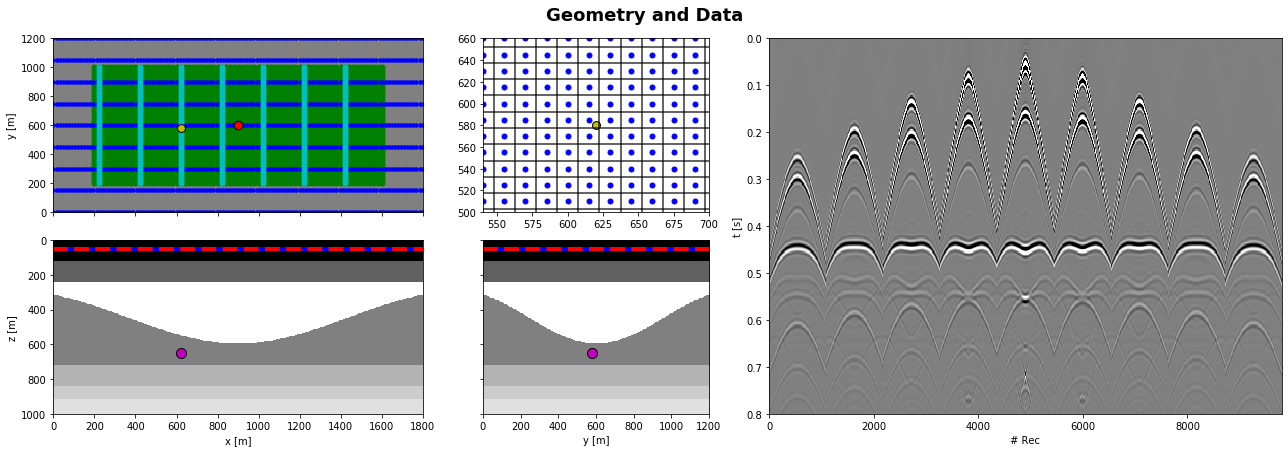

In [7]:
fig = plt.figure(figsize=(18, 6))
plt.suptitle('Geometry and Data', y=1.04, fontsize=18, fontweight='bold')
ax0 = plt.subplot2grid((6, 9), (0, 0), rowspan=3, colspan=3)
ax1 = plt.subplot2grid((6, 9), (3, 0), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((6, 9), (0, 3), rowspan=3, colspan=2)
ax3 = plt.subplot2grid((6, 9), (3, 3), rowspan=3, colspan=2)
ax4 = plt.subplot2grid((6, 9), (0, 5), rowspan=6, colspan=6)

ax0.imshow(rho[:,:,np.argmin(np.abs(z-vs[2]))], cmap='gray', origin='lower',
           vmin=1000, vmax=5000, extent = (x[0], x[-1], y[0], y[-1]))
ax0.scatter(VSX.ravel(), VSY.ravel(), marker='.', s=100, c='g')
ax0.scatter(r[0].reshape(nry, nrx)[::10], r[1].reshape(nry, nrx)[::10], marker='.', s=50, c='b')
ax0.scatter(VSX[1::10], VSY[1::10], marker='.', s=100, c='c')
ax0.scatter(s[0, ns // 2], s[1, ns // 2], marker='.', s=300, c='r', edgecolors='k')
ax0.scatter(vs[0], vs[1], marker='.', s=250, c='y', edgecolors='k')
ax0.axis('tight')
ax0.set_ylabel('y [m]')
ax0.set_xlim(x[0], x[-1])
ax0.set_ylim(y[0], y[-1])

ax0.set_xticklabels([])

ax1.imshow(rho[np.argmin(np.abs(x-vs[1]))].T, cmap='gray', vmin=1000, vmax=5000,
           extent = (x[0], x[-1], z[-1], z[0]))
ax1.axhline(r[2, 0], color='b', lw=4)
ax1.axhline(s[2, 0], color='r', linestyle='--', lw=4)
ax1.scatter(vs[0], vs[2], marker='.', s=400, c='m', edgecolors='k')
ax1.axis('tight')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('z [m]')
ax1.set_xlim(x[0], x[-1])

vertex, vols = voronoi_volumes(r[:2].T)
voronoi_plot_2d(vertex, ax=ax2, show_points=False,
                show_vertices=False, line_colors='k',
                line_width=2, line_alpha=0.6, point_size=10)
ax2.scatter(s[0], s[1], marker='.', s=100, c='b')
ax2.scatter(vs[0], vs[1], marker='.', s=250, c='y', edgecolors='k')
ax2.set_xlim(vs[0]-80, vs[0]+80)
ax2.set_ylim(vs[1]-80, vs[1]+80)

ax3.imshow(rho[np.argmin(np.abs(y-vs[0]))].T, cmap='gray', vmin=1000, vmax=5000,
           extent = (y[0], y[-1], z[-1], z[0]))
ax3.axhline(r[2, 0], color='b', lw=4)
ax3.axhline(s[2, 0], color='r', linestyle='--', lw=4)
ax3.scatter(vs[1], vs[2], marker='.', s=400, c='m', edgecolors='k')
ax3.set_xlabel('y [m]')
ax3.axis('tight')
ax3.set_xlim(y[0], y[-1]);
ax3.set_yticklabels([])

ax4.imshow(Rmid[nt-1:].reshape(nt, nry, nrx)[:, ::10].reshape(nt, 9*nrx), 
           cmap='gray', vmin=-1e-5, vmax=1e-5, extent=(0, nr, t[-1], t[0]))
ax4.axis('tight')
ax4.set_xlabel('# Rec')
ax4.set_ylabel('t [s]')
ax4.set_ylim(0.8, 0.)

plt.tight_layout()
#plt.savefig('Figures/geometry.eps', bbox_inches='tight')
plt.savefig('Figures/geometry.png', dpi=300, bbox_inches='tight')

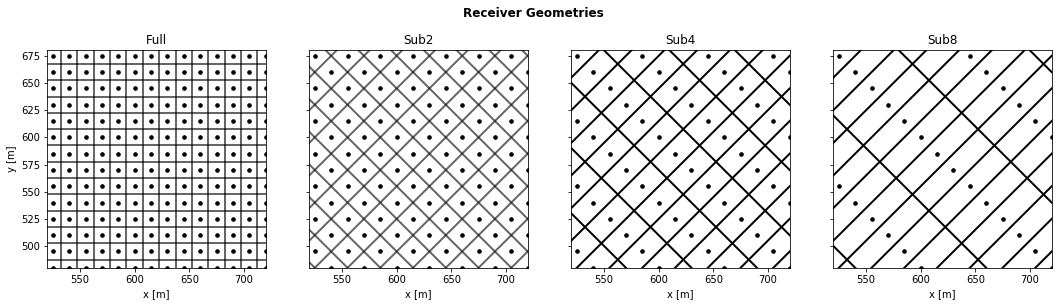

In [8]:
vertex, vols = voronoi_volumes(r[:2].T)
vertex2, vols2 = voronoi_volumes(r2[:2].T)
vertex4, vols4 = voronoi_volumes(r4[:2].T)
vertex8, vols8 = voronoi_volumes(r8[:2].T)

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
fig.suptitle('Receiver Geometries', fontsize=12, fontweight='bold', y=1.03)
voronoi_plot_2d(vertex, ax=axs[0], show_points=False,
                show_vertices=False, line_colors='K',
                line_width=2, line_alpha=0.6, point_size=10)
voronoi_plot_2d(vertex2, ax=axs[1], show_points=False,
                show_vertices=False, line_colors='k',
                line_width=2, line_alpha=0.6, point_size=10)
voronoi_plot_2d(vertex4, ax=axs[2], show_points=False,
                show_vertices=False, line_colors='k',
                line_width=2, point_size=10)
voronoi_plot_2d(vertex8, ax=axs[3], show_points=False,
                show_vertices=False, line_colors='k',
                line_width=2, point_size=10)
axs[0].scatter(r[0], r[1], marker='.', s=50, c='k')
axs[1].scatter(r2[0], r2[1], marker='.', s=50, c='k')
axs[2].scatter(r4[0], r4[1], marker='.', s=50, c='k')
axs[3].scatter(r8[0], r8[1], marker='.', s=50, c='k')
axs[0].set_title('Full')
axs[1].set_title('Sub2')
axs[2].set_title('Sub4')
axs[3].set_title('Sub8')
axs[0].set_ylabel('y [m]')
axs[0].set_xlabel('x [m]')
axs[1].set_xlabel('x [m]')
axs[2].set_xlabel('x [m]')
axs[3].set_xlabel('x [m]')
#axs[0].scatter(vs[0], vs[1], marker='.', s=2000, c='m', edgecolors='k')
for i in range(4):
    axs[i].set_xlim(vs[0]-100, vs[0]+100)
axs[0].set_ylim(vs[1]-100, vs[1]+100)
#plt.savefig('Figures/receivers_layout.eps', bbox_inches='tight')
plt.savefig('Figures/receivers_layout.png', dpi=300, bbox_inches='tight')

Single receiver line comparison

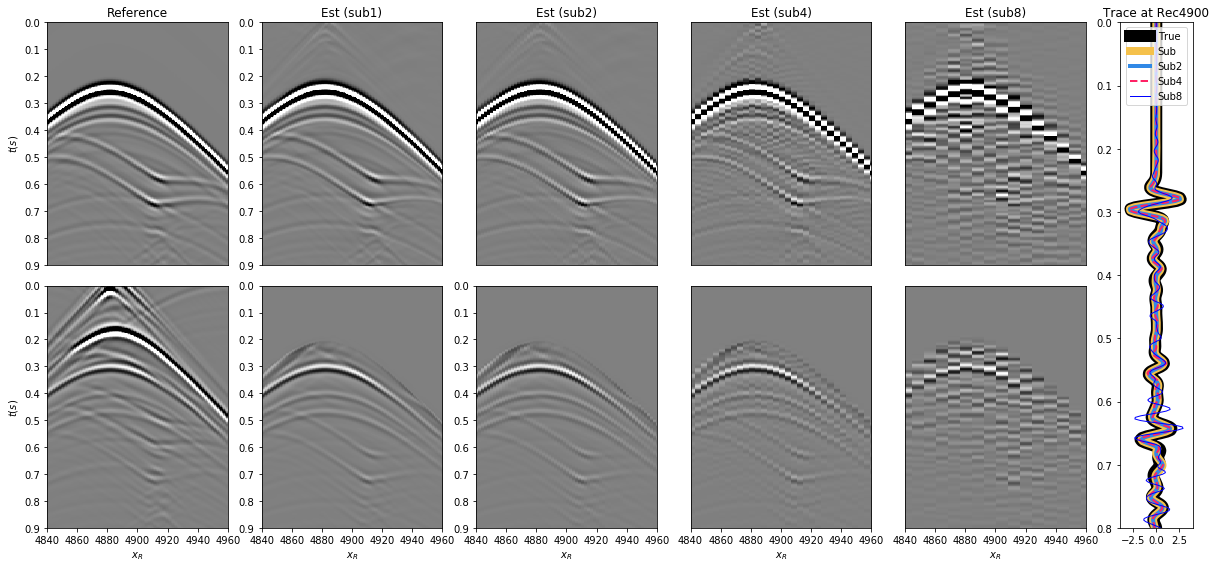

In [9]:
ymax=0.9

fig = plt.figure(figsize=(17, 8))
ax10 = plt.subplot2grid((4, 11), (0, 0), rowspan=2, colspan=2)
ax20 = plt.subplot2grid((4, 11), (2, 0), rowspan=2, colspan=2)
ax11 = plt.subplot2grid((4, 11), (0, 2), rowspan=2, colspan=2)
ax21 = plt.subplot2grid((4, 11), (2, 2), rowspan=2, colspan=2)
ax12 = plt.subplot2grid((4, 11), (0, 4), rowspan=2, colspan=2)
ax22 = plt.subplot2grid((4, 11), (2, 4), rowspan=2, colspan=2)
ax13 = plt.subplot2grid((4, 11), (0, 6), rowspan=2, colspan=2)
ax23 = plt.subplot2grid((4, 11), (2, 6), rowspan=2, colspan=2)
ax14 = plt.subplot2grid((4, 11), (0, 8), rowspan=2, colspan=2)
ax24 = plt.subplot2grid((4, 11), (2, 8), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((4, 11), (0, 10), rowspan=4)

# Full wavefields
ax10.imshow(Gsub, cmap='gray', vmin=-2e3, vmax=2e3, extent=(0, nr, t[-1], t[0]))
ax10.set_title('Reference')
ax10.axis('tight')
ax10.set_ylim(ymax, 0)
ax10.set_xlim(nr//2-60, nr//2+60)
ax10.set_xticks([], [])
ax10.set_ylabel(r'$t(s)$')
ax11.imshow(gest_tot.T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax11.set_xticks([], []), ax12.set_yticks([], [])
ax11.set_title('Est (sub1)')
ax11.axis('tight')
ax11.set_ylim(ymax, 0)
ax11.set_xlim(nr//2-60, nr//2+60)
ax12.imshow(gest2_tot.T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax12.set_xticks([], []), ax12.set_yticks([], [])
ax12.set_title('Est (sub2)')
ax12.axis('tight')
ax12.set_ylim(ymax, 0)
ax12.set_xlim(nr//2-60, nr//2+60)
ax13.imshow(gest4_tot.T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax13.set_xticks([], []), ax13.set_yticks([], [])
ax13.set_title('Est (sub4)')
ax13.axis('tight')
ax13.set_ylim(ymax, 0)
ax13.set_xlim(nr//2-60, nr//2+60)
ax14.imshow(gest8_tot.T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax14.set_xticks([], []), ax14.set_yticks([], [])
ax14.set_title('Est (sub8)')
ax14.axis('tight')
ax14.set_ylim(ymax, 0)
ax14.set_xlim(nr//2-60, nr//2+60)

# Upgoing wavefields
ax20.imshow(p0minus.T, cmap='gray', vmin=-1e3, vmax=1e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax20.axis('tight')
ax20.set_ylim(ymax, 0)
ax20.set_xlim(nr//2-60, nr//2+60)
ax20.set_xlabel(r'$x_R$')
ax20.set_ylabel(r'$t(s)$')
ax21.imshow(gest_minus.T * (1-w.T), cmap='gray', vmin=-1e3, vmax=1e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax21.axis('tight')
ax21.set_ylim(ymax, 0)
ax21.set_xlim(nr//2-60, nr//2+60)
ax21.set_xlabel(r'$x_R$')
ax22.imshow(gest2_minus.T * (1-w2.T), cmap='gray', vmin=-1e3, vmax=1e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax22.axis('tight')
ax22.set_ylim(ymax, 0)
ax22.set_xlim(nr//2-60, nr//2+60)
ax22.set_xlabel(r'$x_R$')
ax23.imshow(gest4_minus.T * (1-w4.T), cmap='gray', vmin=-1e3, vmax=1e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax23.set_yticks([], [])
ax23.axis('tight')
ax23.set_ylim(ymax, 0)
ax23.set_xlim(nr//2-60, nr//2+60)
ax23.set_xlabel(r'$x_R$')
ax24.imshow(gest8_minus.T * (1-w8.T), cmap='gray', vmin=-1e3, vmax=1e3,
            extent=(0, nr, t[-1], -t[-1]))
ax24.set_yticks([], [])
ax24.axis('tight')
ax24.set_ylim(ymax, 0)
ax24.set_xlim(nr//2-60, nr//2+60)
ax24.set_xlabel(r'$x_R$')

# Trace
ax3.plot(np.exp(4*t) * Gsub[:, nr//2+4]/Gsub.max(), t, 'k', lw=12, label='True')
ax3.plot(np.exp(4*t) * gest_tot[nr//2+4, nt-1:]/gest_tot.max(), t, '#f5c14b', lw=8, label='Sub')
ax3.plot(np.exp(4*t) * gest2_tot[nr2//2+2, nt-1:]/gest_tot.max(), t, '#3189e6', lw=4, label='Sub2')
ax3.plot(np.exp(4*t) * gest4_tot[nr4//2+1, nt-1:]/gest_tot.max(), t, '#ff2265', linestyle='--', lw=2, label='Sub4')
ax3.plot(np.exp(4*t) * gest8_tot[nr8//2, nt-1:]/gest_tot.max(), t, 'b', lw=1, label='Sub8')
ax3.set_xlim(-4, 4);
ax3.set_ylim(ymax-0.1, 0);
ax3.legend(fontsize=10, loc='upper center')
ax3.set_title('Trace at Rec%d' % (nr//2))
plt.tight_layout()
#plt.savefig('Figures/gest_comparsion.eps', bbox_inches='tight')
plt.savefig('Figures/gest_comparsion.png', dpi=300, bbox_inches='tight')

Multiple receiver lines comparison

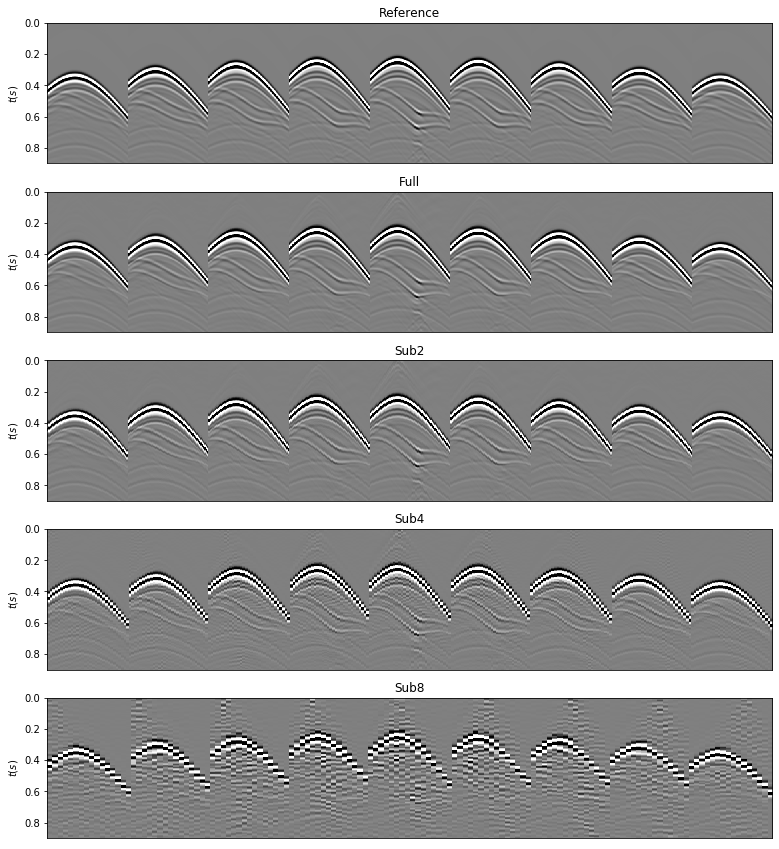

In [10]:
ymax=0.9

rselected = r[1, ::nrx][::10]
irselected = np.isin(r[1, :], rselected) 
ir2selected = np.isin(r2[1, :], rselected) 
ir4selected = np.isin(r4[1, :], rselected) 
ir8selected = np.isin(r8[1, :], rselected) 
ir2irregselected = np.isin(r2irreg[1, :], rselected) 

# Full wavefields
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, sharex=True, figsize=(13, 15))
#fig.suptitle(r'Full wavefield: $\mathbf{G(x_R, x_{VS})}$', fontsize=12, 
#             fontweight='bold', y=0.92)
ax0.imshow(Gsub[:, irselected], cmap='gray', vmin=-2e3, vmax=2e3, extent=(0, nr, t[-1], t[0]))
ax1.set_xticks([], [])
ax0.set_title('Reference')
ax0.axis('tight')
ax0.set_ylim(ymax, 0)
ax0.set_ylabel(r'$t(s)$')
ax1.imshow(gest_tot[irselected].T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax1.set_xticks([], [])
ax1.set_title('Full')
ax1.axis('tight')
ax1.set_ylim(ymax, 0)
ax1.set_ylabel(r'$t(s)$')
ax2.imshow(gest2_tot[ir2selected].T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax2.set_xticks([], [])
ax2.set_title('Sub2')
ax2.axis('tight')
ax2.set_ylim(ymax, 0)
ax2.set_ylabel(r'$t(s)$')
ax3.imshow(gest4_tot[ir4selected].T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax3.set_xticks([], [])
ax3.set_title('Sub4')
ax3.axis('tight')
ax3.set_ylim(ymax, 0)
ax3.set_ylabel(r'$t(s)$')
ax4.imshow(gest8_tot[ir8selected].T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax4.set_title('Sub8')
ax4.axis('tight')
ax4.set_ylim(ymax, 0)
ax4.set_ylabel(r'$t(s)$')
#plt.savefig('Figures/gest_full_comparision.eps', bbox_inches='tight')
plt.savefig('Figures/gest_full_comparision.png', dpi=300, bbox_inches='tight')

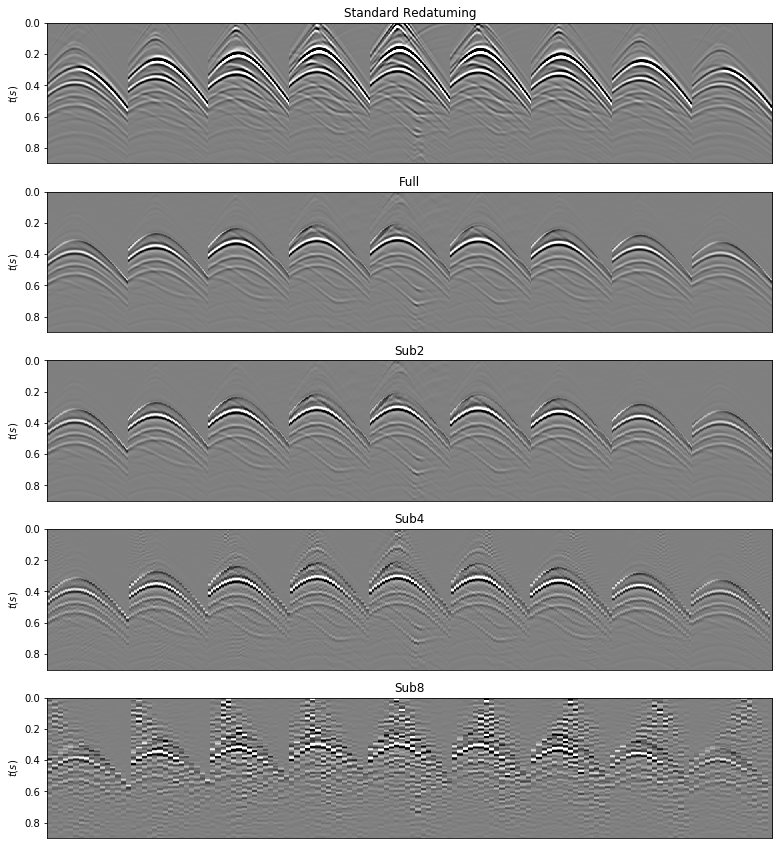

In [11]:
# Upgoing wavefields
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, sharex=True, figsize=(13, 15))
#fig.suptitle(r'Upgoing wavefield: $\mathbf{G^-(x_R, x_{VS})}$', fontsize=12, 
#             fontweight='bold', y=0.92)
ax0.imshow(p0minus[irselected].T, cmap='gray', vmin=-6e2, vmax=6e2, extent=(0, nr, t[-1], -t[-1]))
ax0.set_title('Standard Redatuming')
ax0.axis('tight')
ax0.set_ylim(ymax, 0)
ax0.set_xticks([], [])
ax0.set_ylabel(r'$t(s)$')
ax1.imshow(gest_minus[irselected].T, cmap='gray', vmin=-6e2, vmax=6e2, 
            extent=(0, nr, t[-1], -t[-1]))
ax1.set_xticks([], [])
ax1.set_title('Full')
ax1.axis('tight')
ax1.set_ylim(ymax, 0)
ax1.set_ylabel(r'$t(s)$')
ax2.imshow(gest2_minus[ir2selected].T, cmap='gray', vmin=-6e2, vmax=6e2, 
            extent=(0, nr, t[-1], -t[-1]))
ax2.set_xticks([], [])
ax2.set_title('Sub2')
ax2.axis('tight')
ax2.set_ylim(ymax, 0)
ax2.set_ylabel(r'$t(s)$')
ax3.imshow(gest4_minus[ir4selected].T, cmap='gray', vmin=-6e2, vmax=6e2, 
            extent=(0, nr, t[-1], -t[-1]))
ax3.set_xticks([], [])
ax3.set_title('Sub4')
ax3.axis('tight')
ax3.set_ylim(ymax, 0)
ax3.set_ylabel(r'$t(s)$')
ax4.imshow(gest8_minus[ir8selected].T, cmap='gray', vmin=-6e2, vmax=6e2, 
            extent=(0, nr, t[-1], -t[-1]))
ax4.set_title('Sub8')
ax4.axis('tight')
ax4.set_ylim(ymax, 0)
ax4.set_ylabel(r'$t(s)$')
plt.savefig('Figures/gest_up_comparision.eps', bbox_inches='tight')
plt.savefig('Figures/gest_up_comparision.png', dpi=300, bbox_inches='tight')

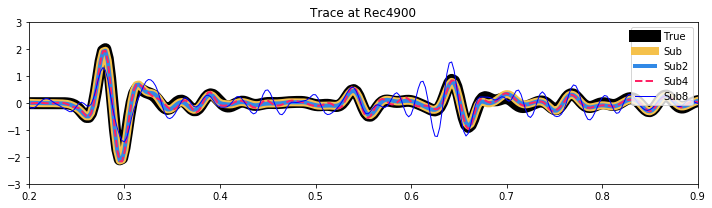

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t, np.exp(3*t) * Gsub[:, nr//2+4]/Gsub.max(), 'k', lw=12, label='True')
ax.plot(t, np.exp(3*t) * gest_tot[nr//2+4, nt-1:]/gest_tot.max(), '#f5c14b', lw=8, label='Sub')
ax.plot(t, np.exp(3*t) * gest2_tot[nr2//2+2, nt-1:]/gest_tot.max(), '#3189e6', lw=4, label='Sub2')
ax.plot(t, np.exp(3*t) * gest4_tot[nr4//2+1, nt-1:]/gest_tot.max(), '#ff2265', linestyle='--', lw=2, label='Sub4')
ax.plot(t, np.exp(3*t) * gest8_tot[nr8//2, nt-1:]/gest_tot.max(), 'b', lw=1, label='Sub8')
ax.set_ylim(-3, 3);
ax.set_xlim(0.2, ymax);
ax.legend(fontsize=10, loc='upper right')
ax.set_title('Trace at Rec%d' % (nr//2))
plt.tight_layout()
plt.savefig('Figures/gest_trace_comparison.eps', bbox_inches='tight')
plt.savefig('Figures/gest_trace_comparison.png', dpi=300, bbox_inches='tight')

Finally we consider the irregular sampling case:

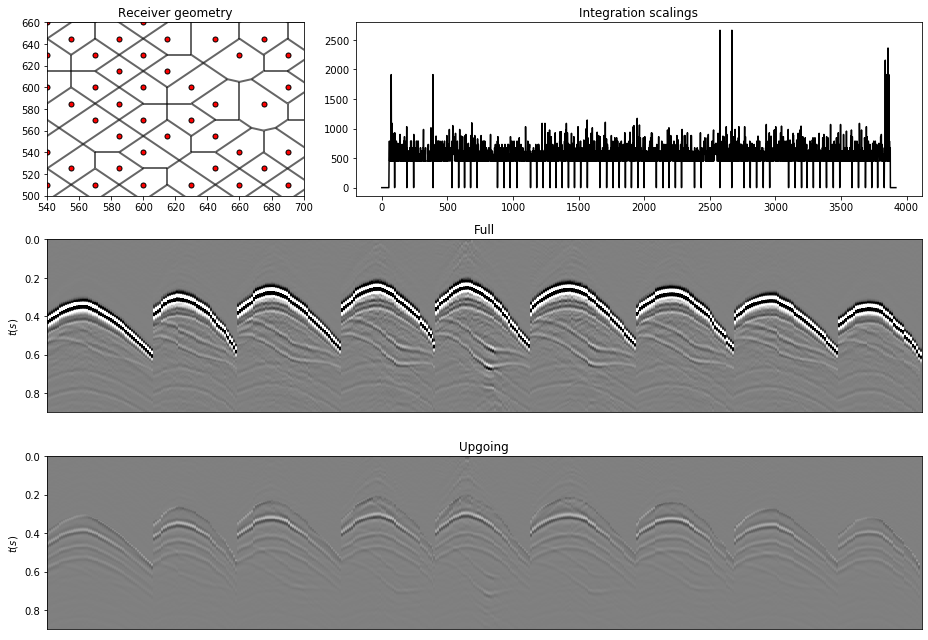

In [31]:
def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return v, vol

# find area of each volume - note that areas at the edges and on vertex are unbounded, ̈́
# we will put them to 0
vertex, dareas = voronoi_volumes(r2irreg[:2].T)
dareas[dareas > 200000] = 0.

fig = plt.figure(figsize=(13, 9))
ax00 = plt.subplot2grid((3, 6), (0, 2), rowspan=1, colspan=4)
ax01 = plt.subplot2grid((3, 6), (0, 0), rowspan=1, colspan=2)
ax10 = plt.subplot2grid((3, 6), (1, 0), rowspan=1, colspan=6)
ax11 = plt.subplot2grid((3, 6), (2, 0), rowspan=1, colspan=6)
ax00.plot(dareas, 'k')
ax00.set_title('Integration scalings')
voronoi_plot_2d(vertex, ax=ax01, show_points=False,
                show_vertices=False, line_colors='k',
                line_width=2, line_alpha=0.6, point_size=10)
ax01.scatter(r2irreg[0], r2irreg[1], marker='.', s=100, c='r', edgecolors='k')
ax01.set_xlim(vs[0]-80, vs[0]+80)
ax01.set_ylim(vs[1]-80, vs[1]+80)
ax01.set_title('Receiver geometry')

ax10.imshow(gest2irreg_tot[ir2irregselected].T, cmap='gray', 
           vmin=-2e3, vmax=2e3, extent=(0, nr, t[-1], -t[-1]))
ax10.set_xticks([], [])
ax10.set_title('Full')
ax10.axis('tight')
ax10.set_ylim(ymax, 0)
ax10.set_ylabel(r'$t(s)$')
ax11.imshow(gest2irreg_minus[ir2irregselected].T, cmap='gray', 
           vmin=-2e3, vmax=2e3, extent=(0, nr, t[-1], -t[-1]))
ax11.set_xticks([], [])
ax11.set_title('Upgoing')
ax11.axis('tight')
ax11.set_ylim(ymax, 0)
ax11.set_ylabel(r'$t(s)$')
plt.tight_layout()
#plt.savefig('Figures/gest_irregular.eps', bbox_inches='tight')
plt.savefig('Figures/gest_irregular.png', dpi=300, bbox_inches='tight')